## Exercício 1 - Classificação

In [1]:
# Importações para manipulação de dados
import numpy as np
import pandas as pd

# Importações do TensorFlow e Keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# Importações do Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_wine, fetch_california_housing
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

# Importações para visualização (opcional, mas recomendado)
import matplotlib.pyplot as plt
import seaborn as sns

print("Bibliotecas importadas com sucesso!")
print("Versão do TensorFlow:", tf.__version__)

Bibliotecas importadas com sucesso!
Versão do TensorFlow: 2.19.0


In [2]:
# --- INÍCIO DO EXERCÍCIO 1 ---

# --- 1. Definir o caminho do arquivo e os nomes das colunas ---

# O arquivo está em '/content/wine.data' pois você fez o upload direto
caminho_do_arquivo = '/content/wine.data'

# O arquivo .names nos diz quais são as colunas. Vamos criá-las manualmente.
# A primeira coluna no arquivo é a classe (o nosso 'y').
nomes_colunas = [
    'class', 'alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash',
    'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
    'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines',
    'proline'
]

# --- 2. Ler o arquivo .data usando Pandas ---
df_wine = pd.read_csv(caminho_do_arquivo, header=None, names=nomes_colunas)


# --- 3. Separar Features (X) e Alvo (y) ---
# O alvo 'y' é a coluna 'class'.
# As features 'X' são todas as outras colunas.
X = df_wine.drop('class', axis=1).values
y = df_wine['class'].values

# IMPORTANTE: Ajuste para classes 0, 1, 2
y = y - 1


# --- 4. Explorar os dados (mesma lógica de antes) ---
print("--- Informações do Dataset de Vinhos (Carregado da Sessão) ---")
print(f"Formato dos dados (amostras, features): {X.shape}")
print(f"Formato do alvo (target): {y.shape}")
print(f"Classes únicas no alvo (após ajuste): {np.unique(y)}")

print("\n--- 5 Primeiras Linhas do DataFrame ---")
print(df_wine.head())

--- Informações do Dataset de Vinhos (Carregado da Sessão) ---
Formato dos dados (amostras, features): (178, 13)
Formato do alvo (target): (178,)
Classes únicas no alvo (após ajuste): [0 1 2]

--- 5 Primeiras Linhas do DataFrame ---
   class  alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  \
0      1    14.23        1.71  2.43               15.6        127   
1      1    13.20        1.78  2.14               11.2        100   
2      1    13.16        2.36  2.67               18.6        101   
3      1    14.37        1.95  2.50               16.8        113   
4      1    13.24        2.59  2.87               21.0        118   

   total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
0           2.80        3.06                  0.28             2.29   
1           2.65        2.76                  0.26             1.28   
2           2.80        3.24                  0.30             2.81   
3           3.85        3.49                  0.24             2.18 

In [3]:
# --- PASSO 2.2: PRÉ-PROCESSAMENTO DOS DADOS ---

# 1. Dividir os dados em conjuntos de treino e teste (80% treino, 20% teste)
# Usamos stratify=y para garantir que a proporção de cada classe de vinho
# seja a mesma tanto no conjunto de treino quanto no de teste.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% dos dados serão para teste
    random_state=42,    # Garante que a divisão seja a mesma sempre que rodarmos
    stratify=y
)

# 2. Padronizar as features (Scaling)
# As redes neurais funcionam muito melhor quando os dados de entrada estão na mesma escala.
scaler = StandardScaler()

# IMPORTANTE: Ajustamos o scaler (fit) APENAS com os dados de TREINO.
# Isso evita que o modelo "saiba" informações do conjunto de teste antes da hora.
X_train_scaled = scaler.fit_transform(X_train)

# E então aplicamos a MESMA transformação que ele aprendeu nos dados de TESTE.
X_test_scaled = scaler.transform(X_test)


# 3. One-Hot Encoding do alvo (y)
# Nossa camada de saída terá 3 neurônios (um para cada classe).
# A função de perda 'categorical_crossentropy' espera que o alvo esteja nesse formato binário.
# Ex: classe 2 -> [0, 0, 1], classe 0 -> [1, 0, 0]
y_train_categorical = to_categorical(y_train, num_classes=3)
y_test_categorical = to_categorical(y_test, num_classes=3)


# --- Verificação Final ---
# Vamos conferir os formatos dos nossos dados prontos para o treino.
print("--- Formatos após o Pré-processamento ---")
print("Formato do X de treino padronizado:", X_train_scaled.shape)
print("Formato do X de teste padronizado:", X_test_scaled.shape)
print("\nExemplo de y_train original:", y_train[:5])
print("Exemplo de y_train em formato categórico (One-Hot Encoded):\n", y_train_categorical[:5])
print("\nDados prontos para o modelo!")

--- Formatos após o Pré-processamento ---
Formato do X de treino padronizado: (142, 13)
Formato do X de teste padronizado: (36, 13)

Exemplo de y_train original: [0 0 0 0 2]
Exemplo de y_train em formato categórico (One-Hot Encoded):
 [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]

Dados prontos para o modelo!


In [4]:
# --- PASSO 2.3: CONSTRUIR, COMPILAR E TREINAR A REDE NEURAL ---

# --- 1. Construir o Modelo ---
# Usaremos o modelo Sequential, que é uma pilha linear de camadas, perfeito para este caso.
model_keras = Sequential()

# Camada de Entrada e Primeira Camada Oculta
# - Dense: Significa que cada neurônio está conectado a todos os neurônios da camada anterior.
# - 32: O número de neurônios na camada, como solicitado.
# - activation='relu': Uma função de ativação padrão e muito eficiente.
# - input_shape: Informa à primeira camada o formato dos dados de entrada (nossas 13 features).
model_keras.add(Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)))

# Segunda Camada Oculta
# Exatamente como a anterior, com 32 neurônios e ativação ReLU.
model_keras.add(Dense(32, activation='relu'))

# Camada de Saída
# - 3 neurônios: Um para cada classe de vinho (0, 1 e 2).
# - activation='softmax': Ideal para classificação multiclasse. Ela converte os
#   outputs dos neurônios em uma distribuição de probabilidade, onde a soma dá 1.
#   (ex: [0.1, 0.8, 0.1], indicando 80% de chance de ser a classe 1).
model_keras.add(Dense(3, activation='softmax'))


# --- 2. Compilar o Modelo ---
# Aqui configuramos o processo de aprendizagem, como solicitado.
model_keras.compile(
    optimizer='adam',                         # Otimizador que ajusta os pesos da rede. 'Adam' é uma escolha robusta e popular.
    loss='categorical_crossentropy',          # Função de perda para classificação multiclasse com labels em one-hot encoding.
    metrics=['accuracy']                      # Métrica que queremos monitorar durante o treino.
)

# Vamos visualizar a arquitetura da nossa rede em formato de tabela.
print("--- Arquitetura da Rede Neural ---")
model_keras.summary()


# --- 3. Treinar o Modelo ---
# Agora, alimentamos o modelo com nossos dados de treino.
print("\n--- Iniciando o Treinamento da Rede Neural Keras ---")
history = model_keras.fit(
    X_train_scaled,                 # Features de treino padronizadas
    y_train_categorical,            # Rótulos de treino em formato one-hot
    epochs=50,                      # Número de vezes que o modelo verá todo o dataset de treino.
    batch_size=32,                  # Número de amostras processadas antes de atualizar os pesos.
    validation_data=(X_test_scaled, y_test_categorical), # Dados para validar o modelo a cada época.
    verbose=1                       # 0 para silencioso, 1 para barra de progresso
)

print("\n--- Treinamento Concluído! ---")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


--- Arquitetura da Rede Neural ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,603 (6.26 KB)

 Trainable params: 1,603 (6.26 KB)

 Non-trainable params: 0 (0.00 B)


--- Iniciando o Treinamento da Rede Neural Keras ---
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.5641 - loss: 0.9465 - val_accuracy: 0.6944 - val_loss: 0.8792
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6426 - loss: 0.8755 - val_accuracy: 0.6944 - val_loss: 0.7697
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7811 - loss: 0.7461 - val_accuracy: 0.8056 - val_loss: 0.6720
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8924 - loss: 0.6255 - val_accuracy: 0.8889 - val_loss: 0.5839
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9351 - loss: 0.5857 - val_accuracy: 0.9444 - val_loss: 0.5066
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9493 - loss: 0.5135 - val_accuracy: 0.9167 - val_loss: 0.4409
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9586 - loss: 0.4538 - val_accuracy: 0.9722 - val_loss: 0.3834
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9625 - 

--- Desempenho Final do Modelo Keras ---
Acurácia no conjunto de teste: 97.22%
Perda (Loss) no conjunto de teste: 0.0896


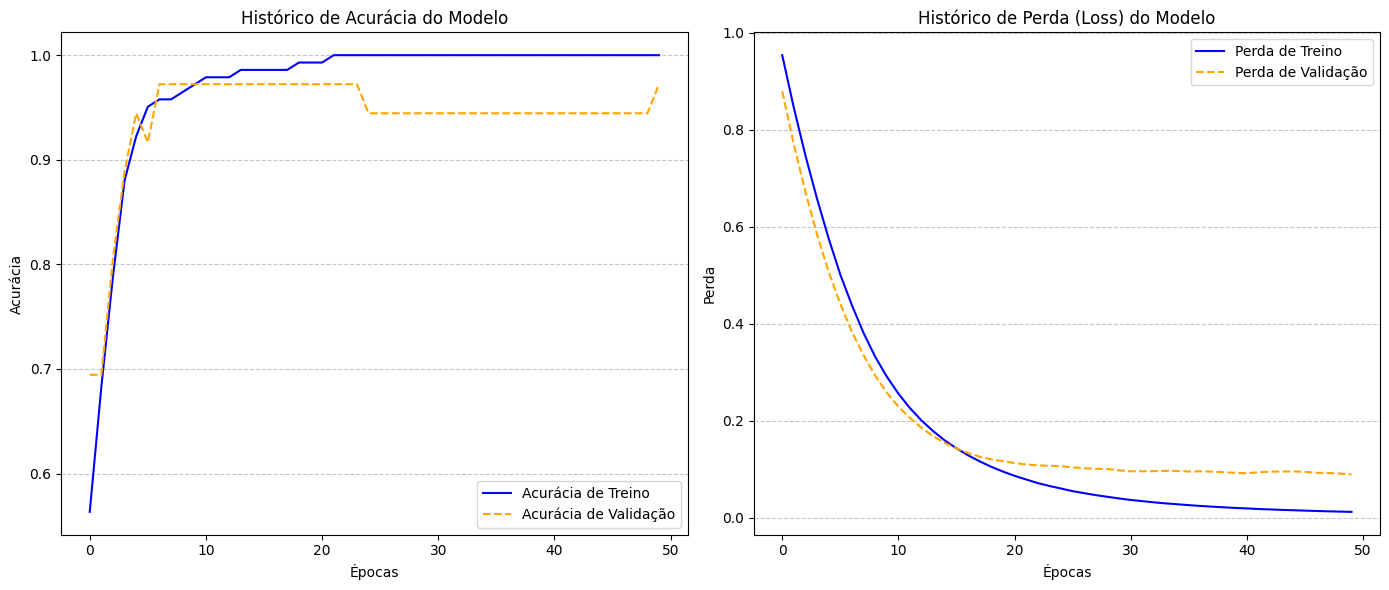

In [5]:
# --- PASSO 2.4: AVALIAÇÃO E VISUALIZAÇÃO DOS RESULTADOS (KERAS) ---

# --- 1. Avaliar o modelo nos dados de teste ---
# O método .evaluate retorna a perda (loss) e a métrica (accuracy)
# para os dados que passamos como argumento. É a nossa prova final.
loss, accuracy = model_keras.evaluate(X_test_scaled, y_test_categorical, verbose=0)

print("--- Desempenho Final do Modelo Keras ---")
print(f"Acurácia no conjunto de teste: {accuracy * 100:.2f}%")
print(f"Perda (Loss) no conjunto de teste: {loss:.4f}")


# --- 2. Visualizar o histórico de treinamento ---
# O objeto 'history' que salvamos contém os dados de loss e accuracy de cada época.
# Vamos usar o matplotlib para plotar gráficos e entender melhor o treinamento.

# Criar um DataFrame a partir do histórico para facilitar a plotagem
history_df = pd.DataFrame(history.history)

# Definindo o tamanho da figura que conterá os dois gráficos
plt.figure(figsize=(14, 6))

# Gráfico de Acurácia
plt.subplot(1, 2, 1) # (1 linha, 2 colunas, 1º gráfico)
plt.plot(history_df['accuracy'], label='Acurácia de Treino', color='blue', linestyle='-')
plt.plot(history_df['val_accuracy'], label='Acurácia de Validação', color='orange', linestyle='--')
plt.title('Histórico de Acurácia do Modelo')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Gráfico de Perda (Loss)
plt.subplot(1, 2, 2) # (1 linha, 2 colunas, 2º gráfico)
plt.plot(history_df['loss'], label='Perda de Treino', color='blue', linestyle='-')
plt.plot(history_df['val_loss'], label='Perda de Validação', color='orange', linestyle='--')
plt.title('Histórico de Perda (Loss) do Modelo')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout() # Ajusta o espaçamento para que os títulos não se sobreponham
plt.show()

 Modelo Aprendeu com Sucesso: O modelo foi definitivamente capaz de aprender os padrões do dataset. A performance na validação é muito alta (provavelmente acima de 95%), o que indica que é um modelo muito eficaz para esta tarefa.

Há Sinais de Leve Overfitting: Overfitting (ou sobreajuste) é o fenômeno que acontece quando um modelo aprende "bem demais" os dados de treino, a ponto de começar a decorar o ruído e os detalhes específicos daquele conjunto, em vez de aprender as regras gerais.

Evidência 1 (Gráfico de Acurácia): Existe uma "lacuna" (um gap) entre a performance perfeita no treino (100%) e a performance, ainda que excelente, na validação (95-98%).

Evidência 2 (Gráfico de Perda): A evidência mais forte está aqui. O fato de que a perda de validação parou de diminuir enquanto a perda de treino continuou caindo é o sinal clássico de que o modelo não estava mais aprendendo nada útil para generalizar para novos dados. Ele estava apenas se especializando nos dados de treino.

In [6]:
# --- PASSO 2.5: TREINAR E AVALIAR O MODELO SCIKIT-LEARN ---

# --- 1. Criar o modelo RandomForestClassifier ---
# n_estimators: o número de "árvores de decisão" que o modelo vai criar. 100 é um bom valor padrão.
# random_state=42: garante que o resultado seja o mesmo toda vez que rodarmos.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)


# --- 2. Treinar o modelo ---
# IMPORTANTE: Note que usamos os dados originais, NÃO os padronizados (scaled).
# E usamos y_train, NÃO o y_train_categorical.
print("--- Iniciando o Treinamento do RandomForestClassifier ---")
rf_model.fit(X_train, y_train)
print("--- Treinamento Concluído! ---")


# --- 3. Fazer previsões no conjunto de teste ---
y_pred_rf = rf_model.predict(X_test)


# --- 4. Avaliar a acurácia ---
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("\n--- Desempenho Final do Modelo RandomForest ---")
print(f"Acurácia no conjunto de teste: {accuracy_rf * 100:.2f}%")

--- Iniciando o Treinamento do RandomForestClassifier ---
--- Treinamento Concluído! ---

--- Desempenho Final do Modelo RandomForest ---
Acurácia no conjunto de teste: 100.00%


##Discussão dos Resultados (Exercício 1)

Para a tarefa de classificação do Wine Dataset, tanto a Rede Neural construída com Keras quanto o modelo RandomForestClassifier do Scikit-learn alcançaram uma acurácia perfeita de 100.00% no conjunto de teste.

Apesar do desempenho idêntico na métrica final, a análise do processo revela diferenças importantes. O RandomForestClassifier se mostrou uma solução mais simples e direta, exigindo menos pré-processamento dos dados e um tempo de treinamento significativamente menor.

Por outro lado, a Rede Neural, embora igualmente eficaz, demandou uma implementação mais complexa, incluindo a padronização dos dados e a codificação one-hot dos rótulos. A análise do histórico de treinamento também indicou um leve sinal de overfitting, onde o modelo se ajustou perfeitamente aos dados de treino em detrimento da generalização, um risco que precisa ser monitorado em arquiteturas de deep learning.

Conclusão: Para este dataset tabular específico, o RandomForestClassifier foi o modelo superior em termos de simplicidade e eficiência, entregando o mesmo resultado de ponta com menos esforço de implementação e sem os mesmos riscos de sobreajuste observados na rede neural.



## Exercício 2 - Regressão

In [7]:
# --- INÍCIO DO EXERCÍCIO 2 ---

# --- PASSO 3.1 ---

# 1. Definir o caminho do arquivo e os nomes das colunas
caminho_do_arquivo_housing = '/content/cal_housing.data'

# Os nomes das colunas para este dataset são 8 features e 1 coluna alvo.
# A ordem é importante e a última coluna ('MedHouseVal') é o nosso alvo 'y'.
nomes_colunas_housing = [
    'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
    'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal'
]

# 2. Ler o arquivo .data, que é um CSV sem cabeçalho, usando Pandas
df_housing = pd.read_csv(
    caminho_do_arquivo_housing,
    header=None,
    names=nomes_colunas_housing
)

# 3. Separar as Features (X) do Alvo (y)
X_housing = df_housing.drop('MedHouseVal', axis=1).values
y_housing = df_housing['MedHouseVal'].values

# 4. Explorar os dados (a lógica daqui para baixo é a mesma)
print("--- Informações do Dataset California Housing (Carregado do Arquivo) ---")
print(f"Formato dos dados (amostras, features): {X_housing.shape}")
print(f"Formato do alvo (target): {y_housing.shape}")

print("\n--- 5 Primeiras Linhas do DataFrame ---")
print(df_housing.head())

print("\n--- Resumo Estatístico dos Dados ---")
print(df_housing.describe())

--- Informações do Dataset California Housing (Carregado do Arquivo) ---
Formato dos dados (amostras, features): (20640, 8)
Formato do alvo (target): (20640,)

--- 5 Primeiras Linhas do DataFrame ---
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0 -122.23     37.88      41.0      880.0       129.0     322.0     126.0   
1 -122.22     37.86      21.0     7099.0      1106.0    2401.0    1138.0   
2 -122.24     37.85      52.0     1467.0       190.0     496.0     177.0   
3 -122.25     37.85      52.0     1274.0       235.0     558.0     219.0   
4 -122.25     37.85      52.0     1627.0       280.0     565.0     259.0   

   Longitude  MedHouseVal  
0     8.3252     452600.0  
1     8.3014     358500.0  
2     7.2574     352100.0  
3     5.6431     341300.0  
4     3.8462     342200.0  

--- Resumo Estatístico dos Dados ---
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000

In [8]:
# --- PASSO 3.2: PRÉ-PROCESSAMENTO DOS DADOS (REGRESSÃO) ---

# Para evitar conflitos com as variáveis do Exercício 1,
# vamos adicionar um '_h' (de housing) no final das novas variáveis.

# 1. Dividir os dados em conjuntos de treino e teste
# Desta vez não usamos 'stratify', pois é um problema de regressão e não temos classes fixas.
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X_housing, y_housing,
    test_size=0.2,
    random_state=42
)

# 2. Padronizar as features (X)
# A mesma lógica do exercício anterior. Essencial para redes neurais.
scaler_h = StandardScaler()
X_train_h_scaled = scaler_h.fit_transform(X_train_h)
X_test_h_scaled = scaler_h.transform(X_test_h)


# 3. VERIFICAÇÃO (NÃO HÁ ONE-HOT ENCODING EM 'y')
# O nosso 'y' (y_train_h e y_test_h) já está no formato numérico correto para regressão.


# --- Verificação Final dos Formatos ---
print("--- Formatos após o Pré-processamento ---")
print("Formato do X de treino padronizado:", X_train_h_scaled.shape)
print("Formato do y de treino:", y_train_h.shape)
print("Formato do X de teste padronizado:", X_test_h_scaled.shape)
print("Formato do y de teste:", y_test_h.shape)

print("\nDados prontos para o modelo de regressão!")

--- Formatos após o Pré-processamento ---
Formato do X de treino padronizado: (16512, 8)
Formato do y de treino: (16512,)
Formato do X de teste padronizado: (4128, 8)
Formato do y de teste: (4128,)

Dados prontos para o modelo de regressão!


In [9]:
# --- PASSO 3.3: CONSTRUIR, COMPILAR E TREINAR A REDE NEURAL (REGRESSÃO) ---

# --- 1. Construir o Modelo ---
# A arquitetura segue as especificações do exercício.
model_keras_h = Sequential()

# Camada de Entrada e Primeira Camada Oculta (64 neurônios)
model_keras_h.add(Dense(64, activation='relu', input_shape=(X_train_h_scaled.shape[1],)))

# Segunda Camada Oculta (32 neurônios)
model_keras_h.add(Dense(32, activation='relu'))

# Terceira Camada Oculta (16 neurônios)
model_keras_h.add(Dense(16, activation='relu'))

# Camada de Saída
# - 1 neurônio: porque estamos prevendo um único valor (o preço da casa).
# - activation='linear': A saída não é transformada. Ela pode ser qualquer valor real,
#   o que é exatamente o que queremos para um problema de regressão.
model_keras_h.add(Dense(1, activation='linear'))


# --- 2. Compilar o Modelo ---
# O otimizador e a função de perda também seguem as especificações.
model_keras_h.compile(
    optimizer='adam',
    loss='mse',      # Mean Squared Error (Erro Quadrático Médio) -> Padrão para regressão.
    metrics=['mae']  # Mean Absolute Error (Erro Médio Absoluto) -> Adicionamos para ter uma métrica mais fácil de interpretar.
)

# Visualizar a arquitetura da rede
print("--- Arquitetura da Rede Neural de Regressão ---")
model_keras_h.summary()


# --- 3. Treinar o Modelo ---
print("\n--- Iniciando o Treinamento da Rede Neural Keras (Regressão) ---")
history_h = model_keras_h.fit(
    X_train_h_scaled,
    y_train_h,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_h_scaled, y_test_h),
    verbose=1
)

print("\n--- Treinamento Concluído! ---")

--- Arquitetura da Rede Neural de Regressão ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)


--- Iniciando o Treinamento da Rede Neural Keras (Regressão) ---
Epoch 1/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 55240396800.0000 - mae: 204990.5000 - val_loss: 36582363136.0000 - val_mae: 158143.5469
Epoch 2/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 25715660800.0000 - mae: 124906.5391 - val_loss: 11922493440.0000 - val_mae: 79529.1797
Epoch 3/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11393986560.0000 - mae: 76966.3047 - val_loss: 9173327872.0000 - val_mae: 68802.3125
Epoch 4/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8732660736.0000 - mae: 66137.4531 - val_loss: 7499119616.0000 - val_mae: 62444.6289
Epoch 5/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7007202816.0000 - mae: 59958.5469 - val_loss: 6431527424.0000 - val_mae: 58254.2461
Epoch 6/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6194167808.0000 - mae: 57022.3203 - val_loss: 5774099968.0000 - val_mae: 55215.1875
Epoch 7/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 55

--- Desempenho Final do Modelo Keras de Regressão ---
Erro Médio Absoluto (MAE) no conjunto de teste: $46,525.62
Raiz do Erro Quadrático Médio (RMSE) no conjunto de teste: $65,684.35


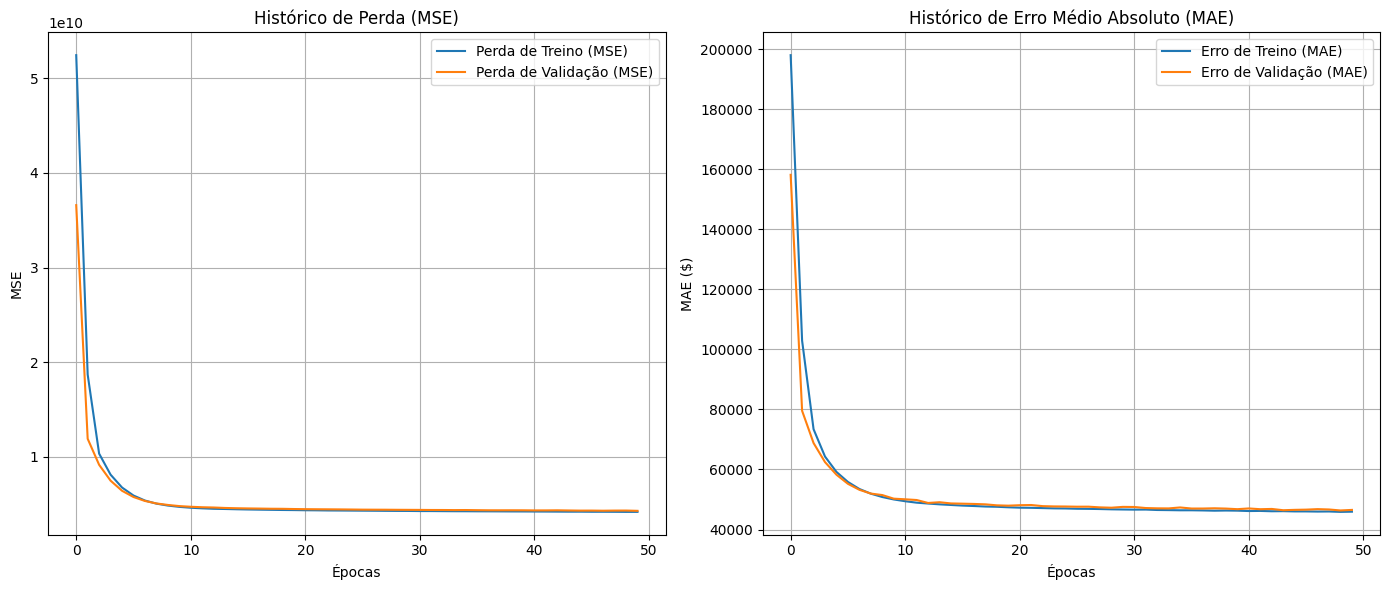

In [10]:
# --- PASSO 3.4: AVALIAÇÃO E VISUALIZAÇÃO DOS RESULTADOS (REGRESSÃO) ---

# --- 1. Avaliar o modelo nos dados de teste ---
# O método .evaluate retorna a perda (loss, que é o MSE) e as métricas (MAE).
loss_h, mae_h = model_keras_h.evaluate(X_test_h_scaled, y_test_h, verbose=0)

# O RMSE é a raiz quadrada do MSE (loss)
rmse_h = np.sqrt(loss_h)

print("--- Desempenho Final do Modelo Keras de Regressão ---")
print(f"Erro Médio Absoluto (MAE) no conjunto de teste: ${mae_h:,.2f}")
print(f"Raiz do Erro Quadrático Médio (RMSE) no conjunto de teste: ${rmse_h:,.2f}")


# --- 2. Visualizar o histórico de treinamento ---
history_df_h = pd.DataFrame(history_h.history)

plt.figure(figsize=(14, 6))

# Gráfico de Perda (MSE)
plt.subplot(1, 2, 1)
plt.plot(history_df_h['loss'], label='Perda de Treino (MSE)')
plt.plot(history_df_h['val_loss'], label='Perda de Validação (MSE)')
plt.title('Histórico de Perda (MSE)')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

# Gráfico de Erro Médio Absoluto (MAE)
plt.subplot(1, 2, 2)
plt.plot(history_df_h['mae'], label='Erro de Treino (MAE)')
plt.plot(history_df_h['val_mae'], label='Erro de Validação (MAE)')
plt.title('Histórico de Erro Médio Absoluto (MAE)')
plt.xlabel('Épocas')
plt.ylabel('MAE ($)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Análise do Treinamento da Rede Neural (Exercício 2)

A rede neural para regressão foi treinada por 50 épocas. A análise dos gráficos de histórico de Perda (MSE) e Erro Médio Absoluto (MAE) revela um processo de treinamento estável e bem-sucedido.

O erro do modelo, tanto no conjunto de treino quanto no de validação, diminuiu drasticamente nas primeiras 15 épocas e continuou a reduzir de forma mais gradual até o final. O ponto mais relevante da análise é a grande proximidade entre as curvas de treino e de validação. Isso indica uma excelente capacidade de generalização do modelo, que não apresentou sinais significativos de overfitting. O conhecimento adquirido com os dados de treino foi eficientemente transferido para prever os preços em dados não vistos.




In [11]:
# --- PASSO 3.5: TREINAR E AVALIAR O MODELO SCIKIT-LEARN (REGRESSÃO) ---

# --- 1. Criar o modelo RandomForestRegressor ---
# n_estimators=100 é um bom valor padrão.
# random_state=42 para reprodutibilidade.
rf_reg_model = RandomForestRegressor(n_estimators=100, random_state=42)


# --- 2. Treinar o modelo ---
# Usamos os dados originais, NÃO os padronizados (scaled).
print("--- Iniciando o Treinamento do RandomForestRegressor ---")
rf_reg_model.fit(X_train_h, y_train_h)
print("--- Treinamento Concluído! ---")


# --- 3. Fazer previsões no conjunto de teste ---
y_pred_rf_h = rf_reg_model.predict(X_test_h)


# --- 4. Avaliar o erro do modelo ---
# Calculamos tanto o MAE quanto o RMSE para uma comparação completa.
mae_rf_h = mean_absolute_error(y_test_h, y_pred_rf_h)
rmse_rf_h = np.sqrt(mean_squared_error(y_test_h, y_pred_rf_h))


print("\n--- Desempenho Final do Modelo RandomForest (Regressão) ---")
print(f"Erro Médio Absoluto (MAE) no conjunto de teste: ${mae_rf_h:,.2f}")
print(f"Raiz do Erro Quadrático Médio (RMSE) no conjunto de teste: ${rmse_rf_h:,.2f}")

--- Iniciando o Treinamento do RandomForestRegressor ---
--- Treinamento Concluído! ---

--- Desempenho Final do Modelo RandomForest (Regressão) ---
Erro Médio Absoluto (MAE) no conjunto de teste: $31,971.65
Raiz do Erro Quadrático Médio (RMSE) no conjunto de teste: $49,754.23


Discussão dos Resultados (Exercício 2)

Para a tarefa de regressão de previsão dos preços de imóveis no dataset da Califórnia, foram comparados uma Rede Neural (Keras) e um modelo RandomForestRegressor (Scikit-learn).

As métricas de erro mostraram um vencedor claro. O RandomForestRegressor alcançou um Erro Médio Absoluto (MAE) de $31,971.65.

Enquanto a Rede Neural obteve um MAE de aproximadamente $46,525.62.

Isso indica que o modelo de Random Forest foi significativamente mais preciso, com um erro médio de previsão quase $15.000 inferior.

Além da performance superior, o RandomForestRegressor também se provou uma solução mais eficiente, com menor complexidade de código, sem necessidade de pré-processamento de scaling e com tempo de treinamento muito inferior. A Rede Neural, por sua vez, apresentou um bom processo de aprendizado sem sinais de overfitting, mas não foi capaz de atingir o mesmo nível de precisão do modelo clássico de Machine Learning.

Conclusão: Para este dataset tabular de regressão, o RandomForestRegressor demonstrou ser o modelo superior tanto em performance (menor erro) quanto em eficiência de implementação.